In [185]:
import os
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression

In [186]:
DATA_DIR = './dms_data'
def load_and_preprocess_data(file_path):
    """CSVを読み込んでちょっと前処理する関数。"""
    df = pd.read_csv(file_path)
    df = df.drop(['timestamp'], axis=1)
    return df.dropna()

def get_data_from_directory(directory_path):
    """指定ディレクトリのCSV全部を読み込んで結合する関数。"""
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    data_frames = [load_and_preprocess_data(os.path.join(directory_path, file)) for file in files]
    return pd.concat(data_frames, ignore_index=True)

def showLgbmModelFeature(model):
    plt.figure(figsize=(10,6))
    lgb.plot_importance(model)
    plt.show()

# トレインデータとテストデータを読み込む
train = get_data_from_directory(os.path.join(DATA_DIR, 'train'))
test = get_data_from_directory(os.path.join(DATA_DIR, 'test'))

# 特徴量を定義
features = [
    'm_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480'
]

In [187]:
train.head()

,m_speed,m_speed_var_480,m_speed_stddev_480,m_acceleration,m_acceleration_var_480,m_acceleration_stddev_480,m_jerk,m_jerk_var_480,m_jerk_stddev_480,m_steering,...,BrakeInput,BrakeInput_var_480,BrakeInput_stddev_480,realtime steering entropy_1100,realtime steering entropy_1100_var_480,realtime steering entropy_1100_stddev_480,perclos,mean_ec_out,oss,Sleepiness
0,69.2,62.888737,7.930242,0.0736,0.003503,0.059185,0.0015,0.000020,0.004417,0.000987,...,0.0,0.000177,0.013288,0.000427,0.0,0.000056,0.294543,1.873714,2.384637,4.0
1,63.4,72.544368,8.517298,-0.1315,0.004115,0.064149,0.0003,0.000020,0.004455,-0.000804,...,0.0,0.000177,0.013302,0.000895,0.0,0.000207,0.228587,0.000009,2.010695,4.0
2,101.0,87.896412,9.375309,0.0644,0.004418,0.066471,-0.0001,0.000020,0.004455,0.000466,...,0.0,0.000177,0.013315,0.000504,0.0,0.000222,0.140712,0.081118,2.135257,4.0
3,86.6,86.736607,9.313249,0.0225,0.004566,0.067569,0.0000,0.000020,0.004480,-0.000063,...,0.0,0.000178,0.013328,0.000000,0.0,0.000224,0.134744,0.000583,2.658373,4.0
4,52.4,80.914104,8.995227,0.0184,0.004323,0.065747,0.0000,0.000017,0.004174,-0.000401,...,0.0,0.000178,0.013338,0.000295,0.0,0.000230,0.133779,0.106500,2.471206,4.0


In [188]:
train.dtypes

m_speed                                      float64
m_speed_var_480                              float64
m_speed_stddev_480                           float64
m_acceleration                               float64
m_acceleration_var_480                       float64
m_acceleration_stddev_480                    float64
m_jerk                                       float64
m_jerk_var_480                               float64
m_jerk_stddev_480                            float64
m_steering                                   float64
m_steering_var_480                           float64
m_steering_stddev_480                        float64
AccelInput                                   float64
AccelInput_var_480                           float64
AccelInput_stddev_480                        float64
BrakeInput                                   float64
BrakeInput_var_480                           float64
BrakeInput_stddev_480                        float64
realtime steering entropy_1100               f

In [189]:
# ossを丸めてint型として新しいカラムoss_intを追加
train['int_oss'] = train['oss'].round().astype(int)
train['int_sleepiness'] = train['Sleepiness'].round().astype(int)
test['int_oss'] = test['oss'].round().astype(int)
test['int_sleepiness'] = test['Sleepiness'].round().astype(int)

# int_ossカラムを追加した新しいデータフレームのdtypeを表示
print(train.dtypes)
print(test.dtypes)

m_speed                                      float64
m_speed_var_480                              float64
m_speed_stddev_480                           float64
m_acceleration                               float64
m_acceleration_var_480                       float64
m_acceleration_stddev_480                    float64
m_jerk                                       float64
m_jerk_var_480                               float64
m_jerk_stddev_480                            float64
m_steering                                   float64
m_steering_var_480                           float64
m_steering_stddev_480                        float64
AccelInput                                   float64
AccelInput_var_480                           float64
AccelInput_stddev_480                        float64
BrakeInput                                   float64
BrakeInput_var_480                           float64
BrakeInput_stddev_480                        float64
realtime steering entropy_1100               f

### LightGBM

In [190]:
def train_lgbm_classificatoin(num_class,train,test):
    params = {
    'objective': 'multiclass', # 多クラス分類
    'num_class': num_class, # クラスの数
    'metric': 'multi_logloss' # 損失関数にmulti_loglossを使用
    }
    model = lgb.train(params, train, num_boost_round=1000, valid_sets=[train,test], early_stopping_rounds=10)
    return model
    

In [191]:
# int_oss
from sklearn.metrics import accuracy_score

X_train_oss = train.drop('int_oss', axis=1).drop('oss',axis=1)
y_train_oss = train['int_oss']
y_train_oss -= 1

X_test_oss = test.drop('int_oss', axis=1).drop('oss',axis=1)
y_test_oss = test['int_oss']
y_test_oss -= 1

train_data_oss = lgb.Dataset(X_train_oss, label=y_train_oss)
test_data_oss = lgb.Dataset(X_test_oss, label=y_test_oss, reference=train_data_oss)

model = train_lgbm_classificatoin(5,train_data_oss,test_data_oss)

y_pred_oss = model.predict(X_test_oss)
y_pred_oss_class = np.argmax(y_pred_oss,axis=1) + 1
y_test_oss += 1

acc = accuracy_score(y_test_oss,y_pred_oss_class)
print('Accuracy:', acc)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5462
[LightGBM] [Info] Number of data points in the train set: 1738, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.491783
[LightGBM] [Info] Start training from score -0.573959
[LightGBM] [Info] Start training from score -1.847362
[LightGBM] [Info] Start training from score -2.917196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's multi_logloss: 0.947342	valid_1's multi_logloss: 1.40269
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 0.841149	valid_1's multi_logloss: 1.3184

/home/buntin/jupyter-env/lib64/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


<Figure size 1000x600 with 0 Axes>

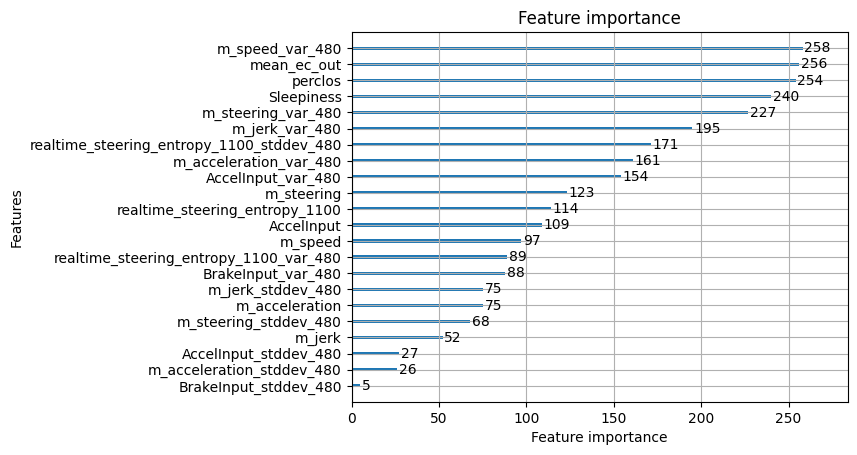

In [192]:
showLgbmModelFeature(model)

In [193]:
# int_sleepinessに対するデータセット準備
X_train_sleepiness = train.drop('int_sleepiness', axis=1)
y_train_sleepiness = train['int_sleepiness']

X_test_sleepiness = test.drop('int_sleepiness', axis=1)
y_test_sleepiness = test['int_sleepiness']

train_data_sleepiness = lgb.Dataset(X_train_sleepiness, label=y_train_sleepiness)
test_data_sleepiness = lgb.Dataset(X_test_sleepiness, label=y_test_sleepiness, reference=train_data_sleepiness)

### GraphNeuralNetwork

In [194]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [195]:
def read_and_process(directory):
    files = os.listdir(directory)
    df_list = []
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            df = df.drop(['timestamp'], axis=1)
            df = df.dropna()
            df_list.append(df)
    df_combined = pd.concat(df_list, ignore_index=True)
    return df_combined

In [196]:
data_dir = 'dms_data'

train_data_path = data_dir + '/train'
test_data_path = data_dir + '/test'


train = read_and_process(train_data_path)
test = read_and_process(test_data_path)
features = ['m_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480']